In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the small Places365 dataset directly from the official link
#!wget http://data.csail.mit.edu/places/places365/places365standard_easyformat.tar

# Create a directory for the small dataset
#!mkdir -p "/content/drive/MyDrive/Colab Notebooks/ComputerVision_AIPI590/data/"

#!mv /content/places365standard_easyformat.tar "/content/drive/MyDrive/Colab Notebooks/ComputerVision_AIPI590/data/"

# Extract the .tar file from the specified Google Drive path
#!tar -xvf "/content/drive/MyDrive/Colab Notebooks/ComputerVision_AIPI590/data/places365standard_easyformat.tar" -C "/content/drive/MyDrive/Colab Notebooks/ComputerVision_AIPI590/data/"

--2024-09-14 17:41:51--  http://data.csail.mit.edu/places/places365/places365standard_easyformat.tar
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.131.233
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.csail.mit.edu/places/places365/places365standard_easyformat.tar [following]
--2024-09-14 17:41:51--  https://data.csail.mit.edu/places/places365/places365standard_easyformat.tar
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26686689280 (25G) [application/x-tar]
Saving to: ‘places365standard_easyformat.tar’

places365standard_e 100%[===================>]  24.85G  46.4MB/s    in 9m 36s  

2024-09-14 17:51:28 (44.2 MB/s) - ‘places365standard_easyformat.tar’ saved [26686689280/26686689280]

tar: /content/places365_small: Cannot open: No such file or directory


In [11]:
# Download and extract the small Places365 training dataset directly into the specified directory
#!wget -O /content/drive/MyDrive/Colab\ Notebooks/ComputerVision_AIPI590/data/train_256_places365standard.tar http://data.csail.mit.edu/places/places365/train_256_places365standard.tar && tar -xvf /content/drive/MyDrive/Colab\ Notebooks/ComputerVision_AIPI590/data/train_256_places365standard.tar -C /content/drive/MyDrive/Colab\ Notebooks/ComputerVision_AIPI590/data/


In [12]:
# Download the training dataset
'''
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to 256x256
    transforms.CenterCrop(224),     # Crop image to 224x224
    transforms.ToTensor()#,          # Convert image to tensor
    #transforms.Normalize(
        #mean=[0.485, 0.456, 0.406], # Normalization values used for pretrained models
        #std=[0.229, 0.224, 0.225])
])
'''
#data_dir = '/content/drive/MyDrive/Colab Notebooks/ComputerVision_AIPI590'

# Download only the training dataset
#dataset_train = datasets.Places365(root=data_dir, split='train-standard',
                            # download=True, transform=data_transform)

'\ndata_transform = transforms.Compose([\n    transforms.Resize((256, 256)),  # Resize image to 256x256\n    transforms.CenterCrop(224),     # Crop image to 224x224\n    transforms.ToTensor()#,          # Convert image to tensor\n    #transforms.Normalize(\n        #mean=[0.485, 0.456, 0.406], # Normalization values used for pretrained models\n        #std=[0.229, 0.224, 0.225])\n])\n'

In [28]:
#train_data_dir = './data/places365_standard/images/data/train/'
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/ComputerVision_AIPI590/data/places365_standard/val/'

In [29]:
class Scenes(Dataset):
    def __init__(self, folder):
        aquarium = glob(folder+'/aquarium/*.jpg')
        bar = glob(folder+'/bar/*.jpg')
        barn = glob(folder+'/barn/*.jpg')
        bathroom = glob(folder+'/bathroom/*.jpg')
        bedroom = glob(folder+'/bedroom/*.jpg')

        self.fpaths = aquarium[:500] + bar[:500]+ barn[:500]+ bathroom[:500]+ bedroom[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        # Shuffle file paths
        from random import shuffle, seed
        seed(10)
        shuffle(self.fpaths)

        # Define class labels
        self.class_to_idx = {
            'aquarium': 0,
            'bar': 1,
            'barn': 2,
            'bathroom': 3,
            'bedroom': 4
        }

        # Assign targets based on class labels
        self.targets = [self.class_to_idx[fpath.split('/')[-2]] for fpath in self.fpaths]
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [30]:
data = Scenes(test_data_dir)
print(len(data))


500


tensor([3.])


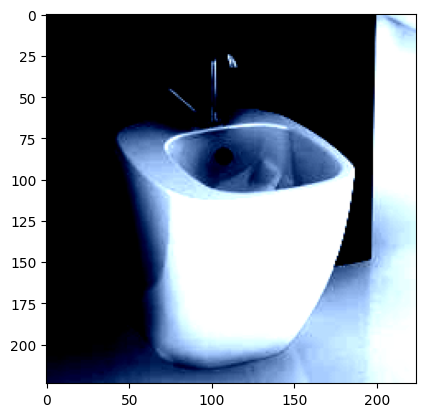

In [32]:
im, label = data[300]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [ ]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/5
 epoch 2/5
 epoch 3/5
 epoch 4/5
 epoch 5/5


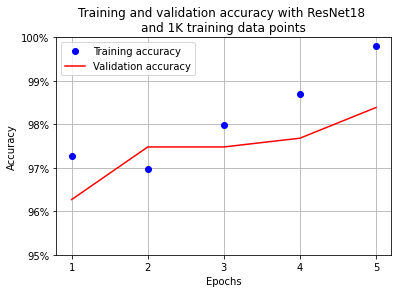

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()